# 使用手寫辨識資料集, 觀察 PCA 算法

# [作業目標]
- 試著模仿範例寫法, 以變更參數後的 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

# [作業重點]
- 以手寫辨識資料集, 觀察變更參數後的 PCA 算法, 在取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [1]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
# PCA 與 羅吉斯迴歸函數
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
# 執行 GridSearchCV 跑出最佳參數
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic_L1 = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
logistic_L2 = SGDClassifier(loss='log', penalty='l2', max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe_L1 = Pipeline(steps=[('pca', pca), ('logistic', logistic_L1)])
pipe_L2 = Pipeline(steps=[('pca', pca), ('logistic', logistic_L2)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [3]:
# 先執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search_L1 = GridSearchCV(pipe_L1, param_grid, iid=False, cv=5, return_train_score=False)
search_L2 = GridSearchCV(pipe_L2, param_grid, iid=False, cv=5, return_train_score=False)

search_L1.fit(X_digits, y_digits)
search_L2.fit(X_digits, y_digits)

print("Best parameter (CV score=%0.3f):" % search_L1.best_score_)
print(search_L1.best_params_)

print("Best parameter (CV score=%0.3f):" % search_L2.best_score_)
print(search_L2.best_params_)

Best parameter (CV score=0.913):
{'logistic__alpha': 0.01, 'pca__n_components': 30}
Best parameter (CV score=0.918):
{'logistic__alpha': 1.0, 'pca__n_components': 30}


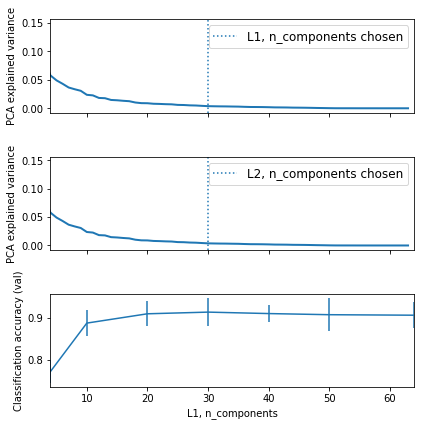

In [4]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
ax0.axvline(search_L1.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='L1, n_components chosen')
ax0.legend(prop=dict(size=12))

ax1.plot(pca.explained_variance_ratio_, linewidth=2)
ax1.set_ylabel('PCA explained variance')
ax1.axvline(search_L2.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='L2, n_components chosen')
ax1.legend(prop=dict(size=12))



# 繪製不同採樣點的分類正確率
results = pd.DataFrame(search_L1.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax2)
ax2.set_ylabel('Classification accuracy (val)')
ax2.set_xlabel('L1, n_components')
plt.tight_layout()
plt.show()

explained variance ratio : 解釋變異性隨著 components 穩定下降
Classification accuracy : 似乎也隨著 components 提升, 但是在 20 以後提升不多

將參數 penalty 改為 L1, max_iter 改為 100 (原本參數 penalty 改為 L2, max_iter 為 10000)
其實兩套參數結果差異不大